| 주차 | 일정                               | 페이지                                  |
|-----:|-----------------------------------|----------------------------------------|
|    1 | 1장-헬로 파이썬                     | 0p ~ 45p                               |
|    2 | 2장-퍼셉트론                        | 46p ~ 62p                              |
|    3 | 3장-신경망                          | 63p ~ 105p                             |
|    4 | 4장-신경망 학습                     | 106p ~ 146p                            |
|    5 | 5장-오차역전파법                    | 147p ~ 187p (+ Appendix A, 292p ~ 299p) |
|    6 | 중간고사(전)                        |                                        |
|    7 | 중간고사                           |                                        |
|    8 | 6장-학습 관련 기술들               | 188p ~ 226p                            |
|    9 | 7장-합성곱 신경망(CNN)             | 227p ~ 259p                            |
|   10 | 딥러닝                             | 261p ~ 308p                            |
|   11 | 1장-신경망 복습                    | 0p ~ 74p (+ Appendix A, 389p ~ 394p)  |
|   12 | 2장-자연어와 단어의 분산 표현      | 78p ~ 113p (+ Appendix B, 395p ~ 399p) |
|   13 | 기말고사(전)                       |                                        |
|   14 | 기말고사                          |                                        |
|   15 | 3장-word2vec                       | 114p ~ 147p                            |
|   16 | 4장-word2vec 속도 개선             | 148p ~ 189p                            |
|   17 | 5장-순환신경망(RNN)                | 190p ~ 235p                            |
|   18 | 6장-게이트가 추가된 RNN            | 263p ~ 286p (+ Appendix C, 401p ~ 402p)|
|   19 | 7장-RNN을 사용한 문장 생성         | 287p ~ 333p                            |
|   20 | 8장-어텐션                         | 334p ~ 387p                            |

# 16주차

word2vec 속도 개선

_148~189p_

---

앞서 언급한 CBOW방식은 말뭉치가 거지면 계산복잡도가 기하급수적으로 늘어나는 단점이 있는데, 이를 해결하기 위해 우리는 신경망을 이용한 Embedding을 만들고 negative sampling또한 사용해서 이 과정이 큰 말뭉치에서도 잘 이루어지도록 할 것이다.

CBOW에서 사용했던 one-hot encoding을 사용할 경우, 어휘가 많아지면 단어별  사용해하는 저장비트의 크기가 기하급수적으로 늘어날 수도 있다는 단점이 있다.

이 첫번째 문제를 해겨하기 위해 우리는 embedding계층을 사용한다. 우리가 CBOW의 첫번째 레이어에서 가중치에 원핫인코딩을 곱하는데, 그냥 이 과정을 생략하고, 그 단어에 해당하는 행 자체를 단어로 표현하는 방식이 바로 embedding이다.

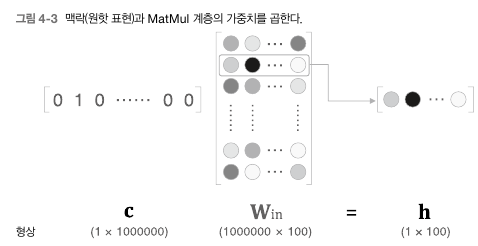

In [ ]:
import numpy as np

class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        # add.at이라는 점에 주목!
        np.add.at(dW, self.idx, dout)
        return None

$W$에서 단어를 추출한다는게(순전파) 사실상 그 행렬에서 해당 행을 빼오는 것이므로, 순전파 적용은 쉽고. 이를 바탕으로 역전파는 해당 행(arr.)을 다시 $W$에 해당하는 행에 집어넣는 것이다.

만약에 역전파 과정에서 같은 행에 해당하는 두 arr.가 역전파를 시도하면 위의 식은 덮어씌워버린다. 이 문제를 해결하기 위해서 우리는 해당하는 행의 값에 더한다. 위의 코드에서는 `np.add.at()`을 사용해서 기존 행에 값을 더해준다.

---

다음으로 해결해야할 속도/병목문제는 2번째 레이어에서의 행렬곱과 뒤에 따르는 softmax함수의 행렬곱 계산이다.

다음 과정에서 $W$의 곱셈과 softmax부분이다.
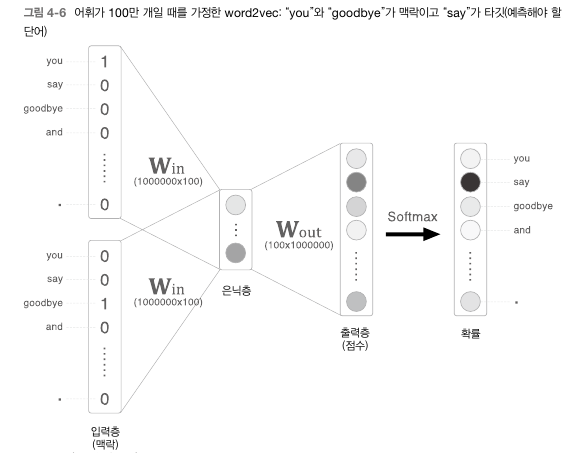

소프트맥스 함수또한 다음과 같으므로
$$
y_k = \frac{\exp(s_k)}{\sum_{i = 1}^{N}\exp(s_i)}
$$
여기서 N이 막 100만개, 1000만개가 된다면 각 단어별로 또 이걸 계산헤야하니 엄청난 양의 계산 시간이 걸릴 것이다.

일단 가장 계산 overhead가 큰 Softmax함수를 쓰는 다중분류 classification모델이라는 문제부터가 있다. 이를 이진분류로 만들 수 있다면 모델을 훨씬 가볍게 만들 수 있을 것이다.

어떻게 이진분류를 이거 만드느냐면:
$$
\text{A와 B 사이에 C-X단어가 들어갈 확률} \to \text{A와 B 사이에 C가 들어갈 수 있나?}
$$